In [1]:
# 1. Find some data. Normally, a DAS query can be used to list remote DQMIO files:
# dasgoclient -query 'file dataset=/SingleMuon/Run2018A-12Nov2019_UL2018-v2/DQMIO' --limit 0
# then, ROOT should be able to open these files if the paths are prefixed with "root://cms-xrd-global.cern.ch/"
# and they are on disk somewhere on the planet.
# However, on Minsky we can't run dasgoclient and reading remote files is slow, so I copied
# about 200GB of DQMIO data to a local folder.
# The same sample is also available on EOS at 
# /eos/user/m/mschneid/SWAN_projects/dqmioplayground/moredqmiodata/_SingleMuon_Run2018A-12Nov2019_UL2018-v2_DQMIO/

#files = open("ibm/dasfilelist", "r").readlines()
#FILELIST = ["root://cms-xrd-global.cern.ch/" + f.strip() for f in files]
#FILELIST[:10]
# forget it, xrootd access is awfully slow/impossible?

In [2]:
DATAPATH = "/nfs/public/mschneid/moredqmiodata/_SingleMuon_Run2018A-12Nov2019_UL2018-v2_DQMIO"

In [3]:
# 2. Read the DQMIO format.
# This format is based on ROOT TTrees and used specifically in CMS DQM. IO is fairly fast,
# partial reads of only a few MEs/LS are possible.
# The code below implements rather efficient DQMIO IO.

import ROOT
import root_numpy
from fnmatch import fnmatch
from collections import namedtuple, defaultdict
from multiprocessing.pool import ThreadPool 
IndexEntry = namedtuple('IndexEntry', ['run', 'lumi', 'type', 'file', 'firstidx', 'lastidx'])
MonitorElement = namedtuple('MonitorElement', ['run', 'lumi', 'name', 'type', 'data'])
NTHREADS=128

def extractdatafromROOT(x):
    if isinstance(x, ROOT.string):
        return unicode(x.data())
    if isinstance(x, int):
        return x
    if isinstance(x, float):
        return x
    else:
        return root_numpy.hist2array(x)

class DQMIOReader:
    treenames = { 
      0: "Ints",
      1: "Floats",
      2: "Strings",
      3: "TH1Fs",
      4: "TH1Ss",
      5: "TH1Ds",
      6: "TH2Fs",
      7: "TH2Ss",
      8: "TH2Ds",
      9: "TH3Fs",
      10: "TProfiles",
      11: "TProfile2Ds",
    }
    """
    Open the passed in files and read their index data.
    The file names go directly to ROOT, remote files like root://cms-xrd-global.cern.ch//store/... should work.
    """
    def __init__(self, *files):
        # for non-local files (/store/...), prefix them with "root://cms-xrd-global.cern.ch/"
        self.rootfiles = [ROOT.TFile.Open(f) for f in files]
        self.readindex()
        self.makelist()
        
    """
    Internal: read index tables.
    """
    def readindex(self):
        self.index = defaultdict(list)
        def readfileidx(f):
            idxtree = getattr(f, "Indices")
            # release GIL in long operations. Disable if it causes trouble.
            #idxtree.GetEntry._threaded = True
            knownlumis = set()

            for i in range(idxtree.GetEntries()):
                idxtree.GetEntry(i)
                run, lumi, metype = idxtree.Run, idxtree.Lumi, idxtree.Type
                if lumi == 0:
                    # read only per-lumi MEs for now.
                    continue
                # inclusive range -- for 0 entries, row is left out
                firstidx, lastidx = idxtree.FirstIndex, idxtree.LastIndex
                e = IndexEntry(run, lumi, metype, f, firstidx, lastidx)
                self.index[(run, lumi)].append(e)
        p = ThreadPool(NTHREADS)
        p.map(readfileidx, self.rootfiles)
        p.close()
                
    """
    Internal: make a cached list for listMEs.
    This is not strictly correct, it just reads a single lumi and assumes all contain the same MEs.
    """
    def makelist(self):
        runlumi = next(iter(self.index.keys()))
        mes = self.getMEsForLumi(runlumi, "*")
        self.melist = dict()
        for me in mes:
            self.melist[me.name] = me.type
    
    """
    Return an iterable with the names of the MEs available per-lumi.
    """
    def listMEs(self):
        return self.melist.keys()
    """
    Returns an iterable of (run, lumi) pairs for the lumis available in the files.
    """
    def listLumis(self):
        return self.index.keys()
    
    """
    Read MEs matching the given wildcard patterns from a single lumi.
    For rootobjects = True, return actual root objects, by default the histogram data is extracted into numpy arrays.
    Returns a list of MonitorElement named tuples.
    """
    def getMEsForLumi(self, runlumi, *namepatterns):
        def check_interesting(mename):
            for pattern in namepatterns:
                if fnmatch(mename,pattern):
                    return True
                return False

        entries = self.index[runlumi]
        if not entries:
            raise IndexError("No data found for this lumisection")
        result = []
        for e in entries:
            metree = getattr(e.file, DQMIOReader.treenames[e.type])
            metree.GetEntry(0)
            metree.SetBranchStatus("*",0)
            metree.SetBranchStatus("FullName",1)
            # release GIL in long operations. Disable if it causes trouble.
            metree.GetEntry._threaded = True
            for x in range(e.firstidx, e.lastidx+1):
                metree.GetEntry(x)
                mename = str(metree.FullName)
                if check_interesting(mename):
                    metree.GetEntry(x, 1)
                    value = metree.Value
                    value = extractdatafromROOT(value)
                    me = MonitorElement(runlumi[0], runlumi[1], mename, e.type, value)
                    result.append(me)
        return result
    
    """
    Read a single ME with the given name from a single lumi.
    This can be much faster than getMEsForLumi when only few MEs are read per lumi.
    For rootobjects = True, return actual root objects, by default the histogram data is extracted into numpy arrays.
    Returns a list of MonitorElement named tuples.
    """
    def getSingleMEForLumi(self, runlumi, name):
        def binsearch(a, key, lower, upper):
            n = upper - lower
            if n <= 1: return lower
            mid = int(n / 2) + lower
            if a(mid) <= key: return binsearch(a, key, mid, upper)
            else: return binsearch(a, key, lower, mid)
        # linear search in case binary search fails.
        def linsearch(a, key, lower, upper):
            for k in range(lower, upper):
                if a(k) == key: return k
            return 0
            
        entries = [e for e in self.index[runlumi] if e.type == self.melist[name]]
        if not entries:
            raise IndexError("No data found for this lumisection")
        for e in entries: # should be only one
            metree = getattr(e.file, DQMIOReader.treenames[e.type])
            metree.GetEntry(0)
            metree.SetBranchStatus("*",0)
            metree.SetBranchStatus("FullName",1)
            # release GIL in long operations. Disable if it causes trouble.
            metree.GetEntry._threaded = True
            
            def searchkey(fullname):
                # split into dir and name, since that is how the DQMStore orders things.
                return ("/".join(fullname.split("/")[:-1]), fullname.split("/")[-1])
            def getentry(idx):
                metree.GetEntry(idx)
                return searchkey(str(metree.FullName))
                
            pos = binsearch(getentry, searchkey(name), e.firstidx, e.lastidx+1)
            metree.GetEntry(pos, 1) # read full row
            if str(metree.FullName) != name:
                return None
            value = metree.Value
            value = extractdatafromROOT(value)
            return MonitorElement(runlumi[0], runlumi[1], name, e.type, value)
        
    """
    Read MEs matching the given wildcard patterns from all lumis.
    For rootobjects = True, return actual root objects, by default the histogram data is extracted into numpy arrays.
    Returns a list of MonitorElement named tuples.
    """
    def getMEs(self, *namepatterns):
        # sum is list concat here.
        return sum((self.getMEsForLumi(lumi, *namepatterns) for lumi in self.listLumis()), [])
    
    """
    Read a single ME with the given name from all lumis.
    This can be much faster than getMEsForLumi when only few MEs are read per lumi. It really tries to be fast.
    For rootobjects = True, return actual root objects, by default the histogram data is extracted into numpy arrays.
    Returns a list of MonitorElement named tuples.
    """
    def getSingleMEs(self, name, callback=None):
        files = defaultdict(list)
        ctr = [0]
        for lumi in self.listLumis():
            files[self.index[lumi][0].file.GetName()].append(lumi)
        def readlumi(lumi):
            l = self.getSingleMEForLumi(lumi, name)
            if callback:
                ctr[0] += 1
                if ctr[0] % 10 == 0:
                    callback(ctr[0])
            return l
        def readfile(f):
            return [readlumi(lumi) for lumi in files[f]]
        p = ThreadPool(NTHREADS)
        result = p.map(readfile, files.keys())
        p.close()
        return sum(result, [])

Welcome to JupyROOT 6.18/04


In [4]:
# 3. Open all the files. Does not read (much) yet.
from glob import glob
%time r = DQMIOReader(*glob(DATAPATH + "/*.root"))

CPU times: user 13.4 s, sys: 588 ms, total: 14 s
Wall time: 13.8 s


In [5]:
# 4. Find some interesting MEs to look at, from the list of ~100K available MEs.
import re
set([re.sub("[0-9]", "?", x) for x in r.listMEs() if x.startswith("RPC")])
#[x for x in r.listMEs() if x.startswith("DT/02-Segments/Wheel1/Sector6/Station2")]

{'RPC/AllHits/Barrel/Wheel_-?/SummaryBySectors/Occupancy_Wheel_-?_Sector_?',
 'RPC/AllHits/Barrel/Wheel_-?/SummaryBySectors/Occupancy_Wheel_-?_Sector_??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/BXDistribution_W-?_RB?++_S??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/BXDistribution_W-?_RB?+_S??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/BXDistribution_W-?_RB?--_S??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/BXDistribution_W-?_RB?-_S??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/BXDistribution_W-?_RB?_S??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/BXDistribution_W-?_RB?in_S??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/BXDistribution_W-?_RB?out_S??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/ClusterSize_W-?_RB?++_S??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/ClusterSize_W-?_RB?+_S??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/ClusterSize_W-?_RB?--_S??',
 'RPC/AllHits/Barrel/Wheel_-?/sector_?/station_?/ClusterSi

In [6]:
# 5. Read a single ME for all LS. This is where actual IO happens.
# The majority of this code is just to get a progress indicator; 
# with warm caches reading a ME should take < 20s on Minsky,
# but it can take minutes to hours with other systems or cold caches!

from IPython import display
from timeit import default_timer

def showcount(ctr):
    global start, lasttime, lastcount
    try: # fails if things are not initialized or the ctr was reset.
        assert(lastcount < ctr)
    except:
        start = default_timer()
        lasttime = default_timer()
        lastcount = 0
    total = len(r.listLumis())
    tottime = default_timer() - start
    deltatime = default_timer() - lasttime
    lasttime = default_timer()
    deltacount = ctr - lastcount
    lastcount = ctr
    display.clear_output(wait=True)
    display.display("Processed %d out of %d lumis in %d s (% 2.0f%%, % 4.2f/s, avg %4.2f/s)" % (ctr, total, tottime, 100.0*ctr/total, deltacount/deltatime, ctr/tottime))

# This specific RPC histogram shows clearly a failure that happend during run 316722.
# The sample data is selected to contain this run (and more).
%time data = r.getSingleMEs("RPC/Muon/SummaryHistograms/NumberOfClusters_Endcap-", callback=showcount)


'Processed 8510 out of 8551 lumis in 5 s ( 100%,  23.38/s, avg 1557.92/s)'

CPU times: user 20min 27s, sys: 20.4 s, total: 20min 47s
Wall time: 20.4 s


In [7]:
# 6. Set up matplotlib to draw into the notebook.

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 8]
%matplotlib inline
import matplotlib.pyplot as plt
import numpy


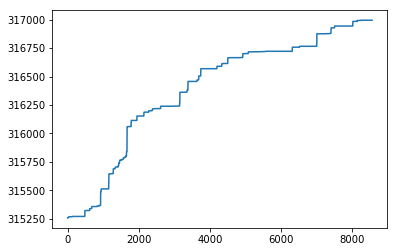

In [8]:
# first, some metadata

run = [me.run for me in sorted(data)]
plt.plot(run)

# we have a lot of random runs from 2018A

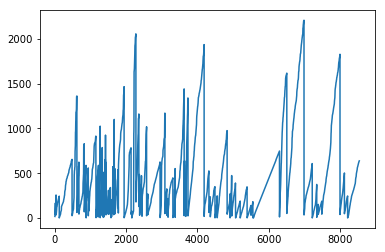

In [9]:
lumi = [me.lumi for me in sorted(data)]
plt.plot(lumi)

# but only for 316722 we have all lumis.

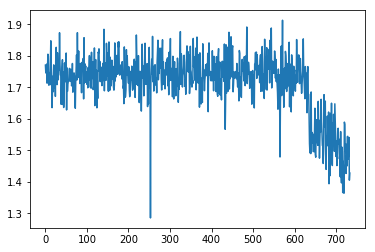

In [10]:
# then, the actual ME data
trend = [sum(me.data*numpy.arange(me.data.shape[0]))/sum(me.data) for me in sorted(data) if me.run == 316722]
plt.plot(trend)

'Processed 8540 out of 8551 lumis in 17 s ( 100%,  29.57/s, avg 480.03/s)'

CPU times: user 19min 11s, sys: 11.2 s, total: 19min 22s
Wall time: 18.9 s


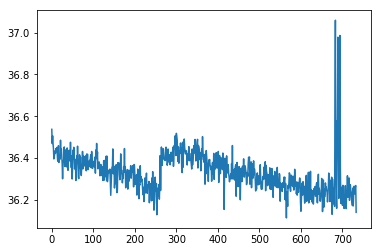

In [11]:
# it turns out there is also a weird anomaly in many other subsystems, in the same run

%time sistripdata = r.getSingleMEs("SiStrip/MechanicalView/MainDiagonal Position", callback=showcount)
sistriptrend = [sum(me.data*numpy.arange(me.data.shape[0]))/sum(me.data) for me in sorted(sistripdata) if me.run == 316722]
plt.plot(sistriptrend)

'Processed 8550 out of 8551 lumis in 13 s ( 100%,  88.70/s, avg 646.19/s)'

CPU times: user 10min 39s, sys: 6.22 s, total: 10min 45s
Wall time: 13.5 s


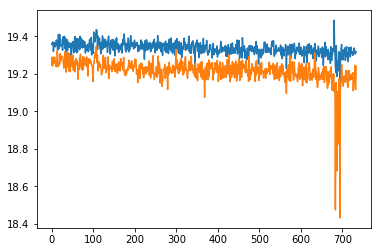

In [12]:
# for technical reasons, we have no per-lumi data of the ECAL barrel
# though maybe some L1T plots could be used.
# We do have the ECAL preshower though.

%time ecaldata = r.getSingleMEs("EcalPreshower/ESOccupancyTask/ES Energy Density Z -1 P 2", callback=showcount)
me = ecaldata[0]
gridx, gridy = numpy.meshgrid(numpy.arange(me.data.shape[1]), numpy.arange(me.data.shape[0]))
# blank out one overflow bin, it is quite massive
for me in ecaldata:
    me.data[39][39] = 0

ecalxtrend = [sum(sum(me.data*gridx))/sum(sum(me.data)) for me in sorted(ecaldata) if me.run == 316722]
plt.plot(ecalxtrend)
ecalytrend = [sum(sum(me.data*gridy))/sum(sum(me.data)) for me in sorted(ecaldata) if me.run == 316722]
plt.plot(ecalytrend)

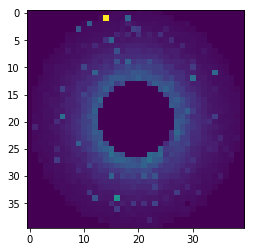

In [13]:
import random
for me in random.sample(ecaldata, 1):
    plt.imshow(me.data)

'Processed 8550 out of 8551 lumis in 221 s ( 100%,  13.86/s, avg 38.53/s)'

CPU times: user 10min 34s, sys: 6.66 s, total: 10min 41s
Wall time: 3min 42s


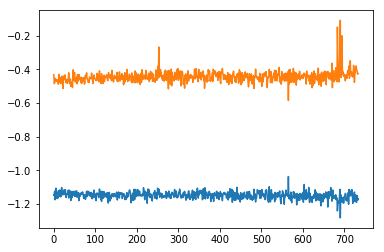

In [14]:
# there is also not much HCAL data, but we do have these occupance maps.

%time hcaldata = r.getSingleMEs("Hcal/DigiPhase1Task/Occupancy/depth/depth5", callback=showcount)

me = hcaldata[0]
gridx, gridy = numpy.meshgrid(numpy.arange(me.data.shape[1]), numpy.arange(me.data.shape[0]))

hcalxtrend = [sum(sum(me.data*gridx))/sum(sum(me.data))-me.data.shape[1]/2.0 for me in sorted(hcaldata) if me.run == 316722]
plt.plot(hcalxtrend)
hcalytrend = [sum(sum(me.data*gridy))/sum(sum(me.data))-me.data.shape[0]/2.0 for me in sorted(hcaldata) if me.run == 316722]
plt.plot(hcalytrend)

In [ ]:
# they look quite weird, but that is the structure of HCAL.

import random
for me in random.sample(hcaldata, 1):
    plt.imshow(me.data)

In [ ]:
# all the trends in one figure.

plt.plot(hcalytrend, label="HCAL Occupancy center-of-mass Y")
plt.plot(numpy.array(ecalytrend)-20, label="ECAL Preshower Occupancy, center-of-mass Y")
plt.plot(numpy.array(sistriptrend)-35, label="SiStrip/SiPixel main diagonal position mean")
plt.plot(trend, label="RPC EndCap- nubmer of clusters mean")

plt.xlabel("LS# in run 316722")
plt.ylabel("arbitrary units")
plt.legend()


In [ ]:
# 7. Now do some machine learning to find anomalies such as this!